In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from wordcloud import WordCloud
import gensim
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix

# Load data_vraag from file

In [3]:
import pickle
data_vraag = pickle.load(open('preprocessedData.pkl', 'r'))

In [4]:
data_ppl = data_vraag[data_vraag['individu of groep']=='mijzelf']
data_org = data_vraag[data_vraag['individu of groep']!='mijzelf']

In [5]:
vraagTokens = data_vraag['SentToks'].tolist()

In [6]:
dic = gensim.corpora.Dictionary(vraagTokens)
corpus = [dic.doc2bow(text) for text in vraagTokens]

In [7]:
data = []
row  = []
col  = []
for n,doc in enumerate(corpus):
    for w,c in doc:
        col.append(n)
        row.append(w)
        data.append(c)

nSamples = len(corpus)
nFeatures = len(dic)
mm = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))

In [8]:
print "nSamples (docs) : ",nSamples
print "nFeatures(words): ",nFeatures
len(corpus),len(dic)

nSamples (docs) :  11700
nFeatures(words):  56266


(11700, 56266)

In [9]:
nTopics = 10
lda = LatentDirichletAllocation(n_topics=nTopics, max_iter=5,
                                learning_method='online', learning_offset=50.
                                #,random_state=0
                               )
lda.fit(mm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [10]:
def getDocumentTopics(docTokens, lda):
    wcTuples = dic.doc2bow(docTokens)
    data = []
    row  = []
    col  = []

    for w,c in wcTuples:
        col.append(0)
        row.append(w)
        data.append(c)

    nSamples = 1
    nFeatures = len(dic)
    oneDoc = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))
    docWeights = lda.transform(oneDoc)[0]
    docWeights /= docWeights.sum()
    return docWeights

In [11]:
topicWords = []
topicWeightedWords = []

for topic_idx, topic in enumerate(lda.components_):
    weightedWordIdx = topic.argsort()[::-1]
    wordsInTopic = [dic[i] for i in weightedWordIdx[:10]]

    weights = topic / topic.sum()
    topicWeights = [ (weights[i],dic[i]) for i in weightedWordIdx[:10]]
    
    print "Topic #%d:" % topic_idx
    print " ".join(wordsInTopic)
    topicWords.append(wordsInTopic)
    topicWeightedWords.append(topicWeights)

Topic #0:
health care research disease patients new treatment people development netherlands
Topic #1:
kinderen onderzoek kind ziekte hersenen klachten behandeling hart patiënten ouders
Topic #2:
basisinkomen straling draadloze information lange-termijn oneindig knooppunten magnesium supergeleiding multimodale
Topic #3:
longziekten constructie gemengde bim antidepressiva schaliegas multi-scale longkanker response longaanval
Topic #4:
future fundamental physics leiding visiedocument nlr ruimtevaart insecten human hepatitis
Topic #5:
energie water duurzame brandstoffen zon elektrische fossiele elektriciteit wind warmte
Topic #6:
vrouwen mannen zeeland vliegtuigen lichaamseigen wkn getal neus top-tien bevalling
Topic #7:
mensen nieuwe maken mogelijk steeds vraag grote onderzoek leven nodig
Topic #8:
waarom muziek aarde mens massa wel stof komt zwaartekracht dood
Topic #9:
onderzoek sociale vraag samenleving ontwikkeling maatschappelijke onderwijs rol nederland kennis


In [12]:
def inRange(age, targetAge, delta):
    return (targetAge-delta)<=age and age<=(targetAge+delta)

def getPplCirca(targetAge, delta):
    return data_ppl[data_ppl['Leeftijd'].apply(lambda age: inRange(age,targetAge, delta))]

In [13]:
topicsByAge = np.zeros((data_ppl['Leeftijd'].max()+1, nTopics))
deltaAge = 5

for age in arange(data_ppl['Leeftijd'].max()+1): 
    dataGroup = getPplCirca(age,deltaAge)
    groupTokens = dataGroup['SentToks'].tolist()
    
    for qTokens in groupTokens:
        topicWeights = getDocumentTopics(qTokens, lda)
        for topic,weight in enumerate(topicWeights):
            topicsByAge[age,topic] += weight / len(groupTokens)

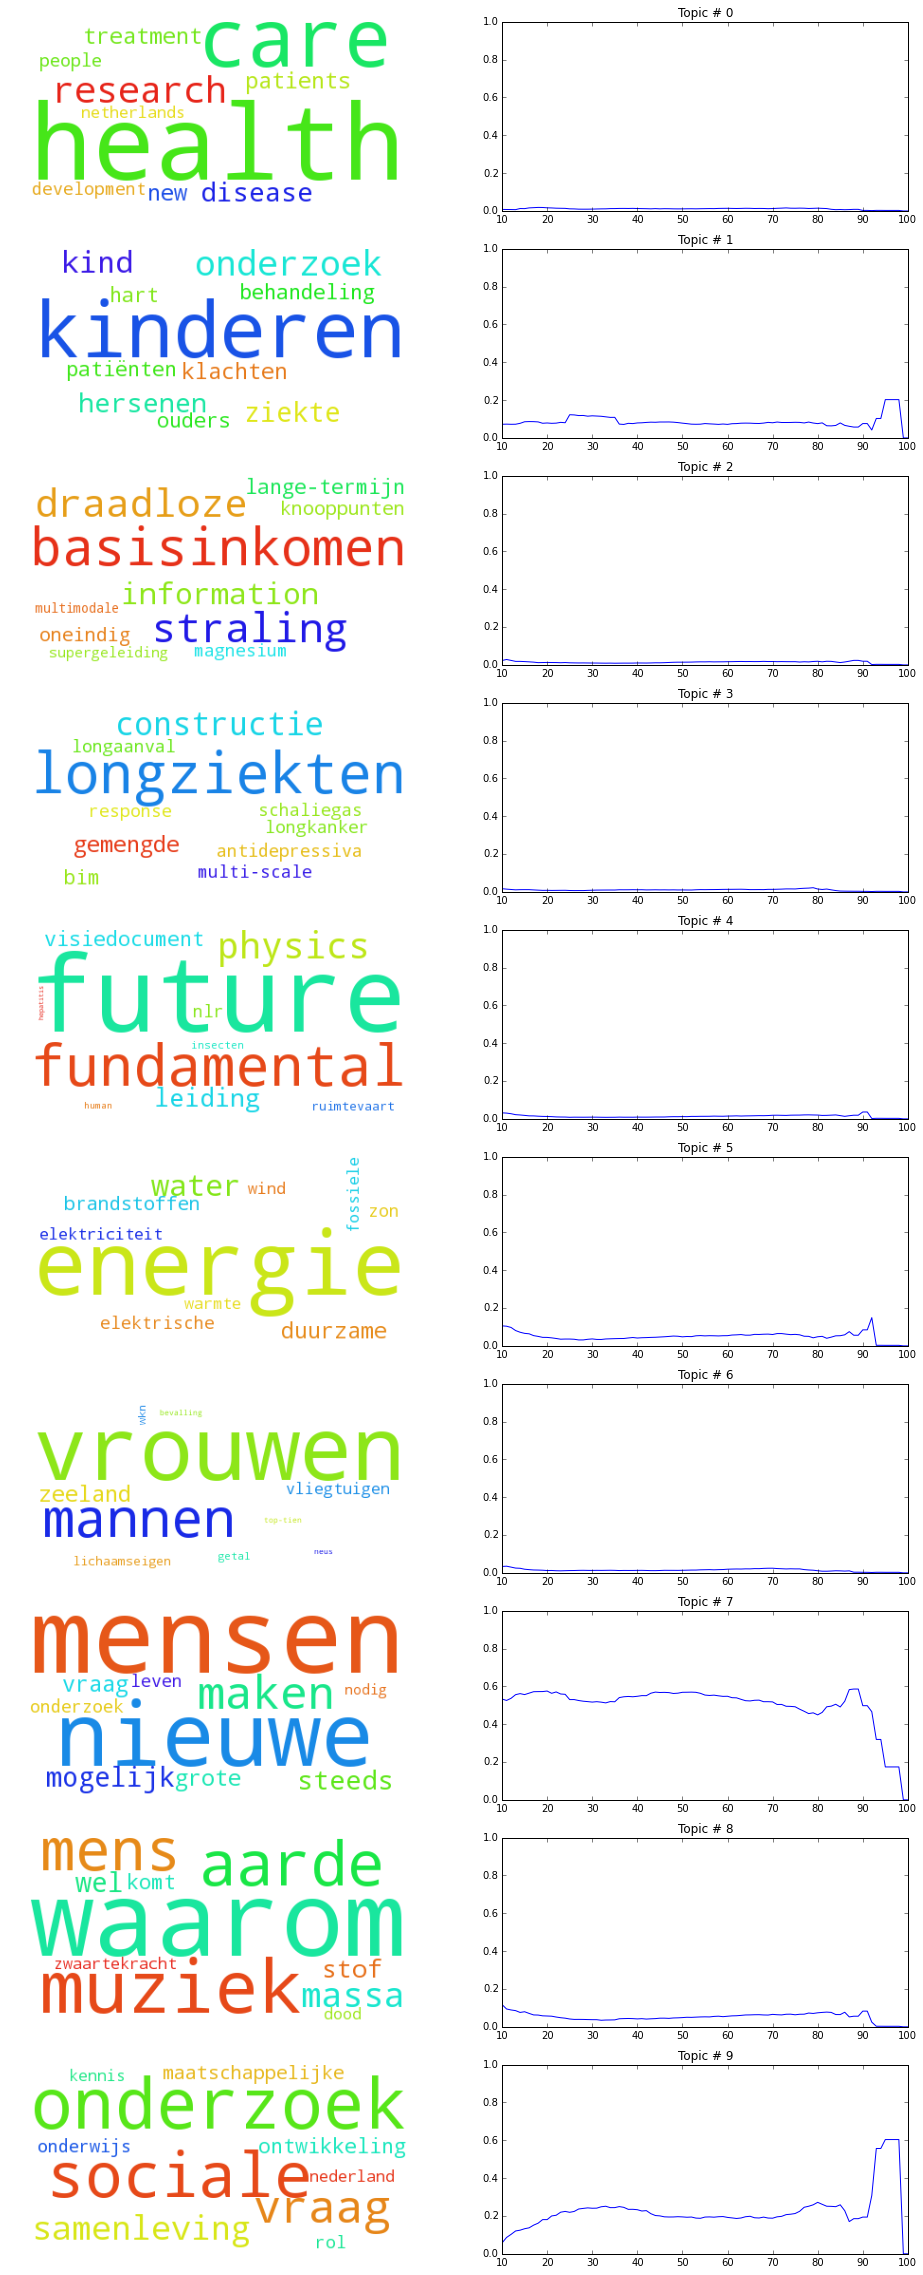

In [14]:
figure(figsize=(16,40))
for idx,topic in enumerate(topicWeightedWords):
    wc = WordCloud(background_color="white", relative_scaling=0.9)
    img = wc.generate_from_frequencies([ (word, weight) for weight,word in topic ])
    subplot(nTopics,2,2*idx+1)
    imshow(img)
    axis('off')
    
    subplot(nTopics,2,2*idx+2)
    plot(topicsByAge[:,idx])
    axis([10, 100, 0, 1.0])
    title('Topic #%2d'%(idx))